In [2]:
!unzip Suicide_Detection.csv.zip
!rm Suicide_Detection.csv.zip

Archive:  Suicide_Detection.csv.zip
  inflating: Suicide_Detection.csv   


In [3]:
!pip install neattext
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 6.1 MB/s eta 0:00:00


In [6]:
!pip install keras.preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import neattext.functions as nfx
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,GlobalMaxPooling1D,Input
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

In [11]:
data = pd.read_csv('Suicide_Detection.csv')

In [12]:
data.shape

(232074, 3)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [14]:
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [16]:
data['class'].value_counts()

,count
class,
suicide,116037
non-suicide,116037


In [17]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

In [19]:
train_data['class'].value_counts()

,count
class,
suicide,92831
non-suicide,92828


<ipython-input-28-17b21e573d2e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='class',palette='tab10')


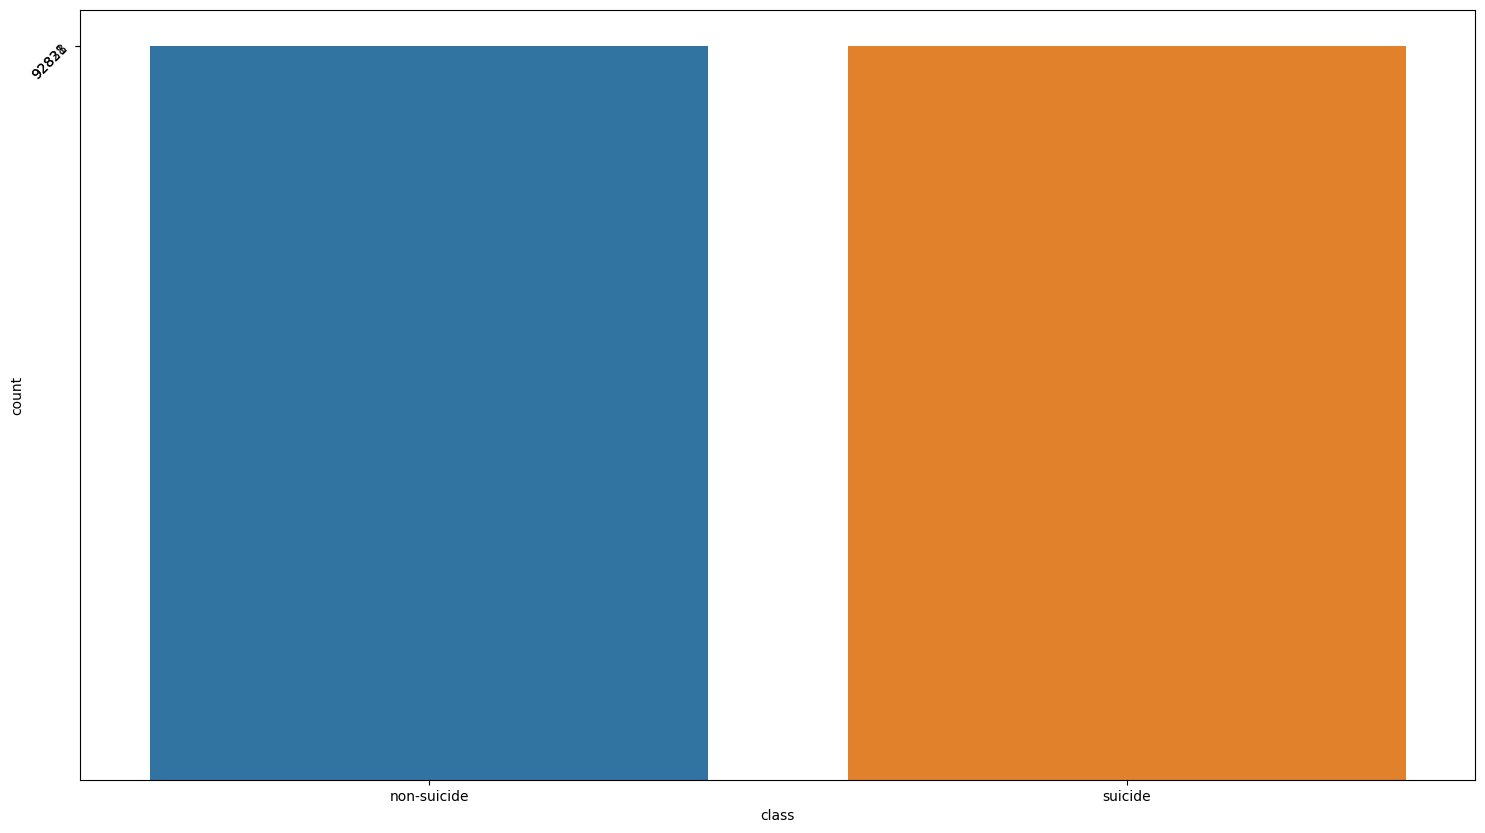

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))
sns.countplot(data=train_data, x='class',palette='tab10')
plt.yticks(train_data['class'].value_counts(),rotation=45)
plt.show()


In [29]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [30]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|██████████| 46415/46415 [00:03<00:00, 13203.92it/s]


In [31]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [33]:
cleaned_train_text[:10]

['hey east cost ya guys doin whats snow like',
 'ate edible ate edible looking fun stuff sitting suggestions',
 'helplessness havelast week ive realised dont like cant stsy happy long dont feel like belong dont know want know people miss die thats stops dont know im meant knowing thatthe times recently ive felt close happy im drinking following day regardless happens feel worse suicidal feelings worse',
 'want win election labeled discussion fight insult personally im hoping trump fact helps expect vote biden helped',
 'toothpicksso thing cant lie doctors family basically push door doctors office came tumbling feel world better lives people im better leaves doctor contacting family saying im allowed things case needed supervision pretty predictable know knifes rope razor blades etc toothpicks mean im flattered think creative kill toothpick honestly feels excessive forcing bubble wrapped getting help making feel worse pressure puts family gonna push guilt able things away isnt fair',
 '

In [45]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [46]:
train_text_pad

array([[   0,    0,    0, ...,  176, 3027,    3],
       [   0,    0,    0, ...,  163,  508, 1642],
       [   0,    0,    0, ...,   77,  240,   96],
       ...,
       [   0,    0,    0, ...,  328,    2,    4],
       [   0,    0,    0, ...,   65,   26,   16],
       [   4,   46,   25, ...,    2,    4,   16]], dtype=int32)

In [34]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [36]:
train_output[0:5]

array([0, 0, 1, 0, 1])

In [37]:
glove_embedding = {}

file_path = '/content/glove.6B.300d.txt'

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]  # The first value is the word
        vector = list(map(float, values[1:]))  # The rest are the vector components
        glove_embedding[word] = vector


In [38]:
glove_embedding['hello']

[-0.33712,
 -0.21691,
 -0.0066365,
 -0.41625,
 -1.2555,
 -0.028466,
 -0.72195,
 -0.52887,
 0.0072085,
 0.31997,
 0.029425,
 -0.013236,
 0.43511,
 0.25716,
 0.38995,
 -0.11968,
 0.15035,
 0.44762,
 0.28407,
 0.49339,
 0.62826,
 0.22888,
 -0.40385,
 0.027364,
 0.0073679,
 0.13995,
 0.23346,
 0.068122,
 0.48422,
 -0.019578,
 -0.54751,
 -0.54983,
 -0.034091,
 0.0080017,
 -0.43065,
 -0.018969,
 -0.08567,
 -0.81123,
 -0.2108,
 0.37784,
 -0.35046,
 0.13684,
 -0.55661,
 0.16835,
 -0.22952,
 -0.16184,
 0.67345,
 -0.46597,
 -0.031834,
 -0.26037,
 -0.17797,
 0.019436,
 0.10727,
 0.66534,
 -0.34836,
 0.047833,
 0.1644,
 0.14088,
 0.19204,
 -0.35009,
 0.26236,
 0.17626,
 -0.31367,
 0.11709,
 0.20378,
 0.61775,
 0.49075,
 -0.07521,
 -0.11815,
 0.18685,
 0.40679,
 0.28319,
 -0.1629,
 0.038388,
 0.43794,
 0.088224,
 0.59046,
 -0.053515,
 0.038819,
 0.18202,
 -0.27599,
 0.39474,
 -0.20499,
 0.17411,
 0.10315,
 0.25117,
 -0.36542,
 0.36528,
 0.22448,
 -0.97551,
 0.094505,
 -0.17859,
 -0.30688,
 -0.58633

In [39]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [40]:
embedding_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.17876 , -0.56186 ,  0.048086, ...,  0.81069 , -0.20186 ,
         0.29167 ],
       [-0.32707 , -0.33259 , -0.042184, ...,  0.22715 ,  0.76067 ,
         0.20132 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-0.11899 , -0.13953 ,  0.51813 , ..., -0.08798 ,  0.22247 ,
         0.20452 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [41]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [42]:
model=Sequential()
model.add(Input(shape=(40,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 40, 300)             │      81,560,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 40, 20)              │          25,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 20)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,592,013 (311.25 MB)

 Trainable params: 31,313 (122.32 KB)

 Non-trainable params: 81,560,700 (311.13 MB)

In [47]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7807 - loss: 0.4614 - val_accuracy: 0.8775 - val_loss: 0.2957 - learning_rate: 0.1000
Epoch 2/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8947 - loss: 0.2652 - val_accuracy: 0.9014 - val_loss: 0.2461 - learning_rate: 0.1000
Epoch 3/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9027 - loss: 0.2435 - val_accuracy: 0.9049 - val_loss: 0.2382 - learning_rate: 0.1000
Epoch 4/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9085 - loss: 0.2321 - val_accuracy: 0.9083 - val_loss: 0.2291 - learning_rate: 0.1000
Epoch 5/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9124 - loss: 0.2236 - val_accuracy: 0.8981 - val_loss: 0.2532 - learning_rate: 0.1000
Epoch 6/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9167 - loss: 0.2137 - val_accuracy: 0.9173 - val_loss: 0.2141 - learning_rate: 0.1000
Epoch 7/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9192 - loss: 0.208

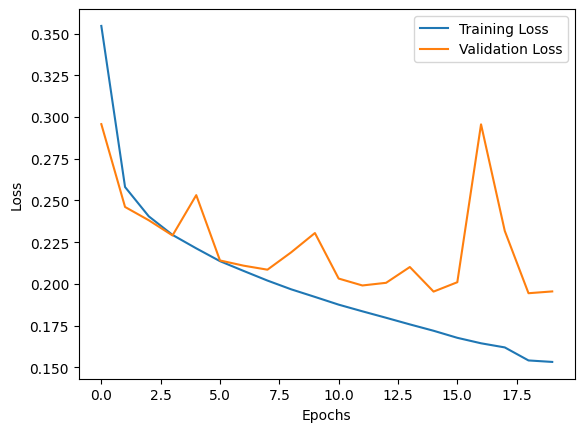

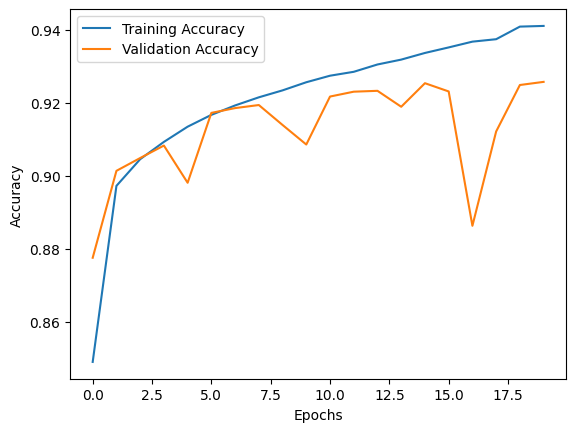

In [50]:

plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import f1_score

y_pred_probs = model.predict(test_text_pad)  # Probabilities
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate F1 Score
f1_score(test_output, y_pred)

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


0.9249378841375703

In [52]:
twt = ['i am happy']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=50)

prediction = model.predict(twt)[0][0]
print(prediction)

if(prediction > 0.5):
    print("Potential Suicide Post")
else:
    print("Non Suicide Post")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0.41793728
Non Suicide Post


In [54]:
import pickle
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [55]:
model.save("model.h5")

In [57]:
token_form = pickle.load(open('tokenizer.pkl', 'rb'))

In [58]:
from keras.models import load_model
model_form = load_model("model.h5")


In [59]:
twt = ['Through these past years thoughts of suicide, fear, anxiety I’m so close to my limit']
twt = token_form.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=50)


prediction = model_form.predict(twt)[0][0]
print(prediction)

if(prediction > 0.5):
    print("Potential Suicide Post")
elif (prediction == 1):
    print("Non Suicide Post")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
0.9747473
Potential Suicide Post
